# Age from face

Predict age of a person from an image of their face. As a training dataset we used a datasat available from Kaggle which uses portrait images from IMDB for which the age of persons is known. We try several approaches for age classification using Keras to define deep neural networks includung both classification and regression. From the neural network toolbox we use the so-called Adam optimizer, dropout regularization and batch normalization.

According to Han & Otto ("Age-Estimation from Face Images: Human vs. Machine Performance", see below) the Bayes Error for this task is larger than 5, i.e. an absolute mean derivation of age estimation from facial images is expected when the task is perfomed by trained humans. One of the approaches tried out achieve a similar performance, but seem to overfit the training data.

To illustrate the fact that the task is not easy for humans, we close with an interactive part where the user can conpare his or her own estimation against both the predicted age and the actual age of a person.

Note that the actual data is not contained in the repository but needs to be downloaded separately from Kaggle - the link can be found at the bottom of this page under "Additional Links".

### Project Repo 
https://github.com/buckcri/age-from-face

## Participants:
Oskar Lachnit, Florian Diedrich, Nils-Christian Buck

### Course and Semester
Deep Learning from Scratch, WiSe2122

### License

This work is licensed under the AGPL-3.0 Licence, please see the following link.

https://www.gnu.org/licenses/agpl-3.0.en.html

First of all, the Python environment has to be set up and the available data have to be made accessible. Fortunately, conversion of data which is already classifed in the file system is possible via a helper function defined in Keras. The fourth
cell defines two helper functions for visualization and evaluation which are not important right now.

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#Note that we deleted folders for age larger than 93 because there were few files, but gaps (e.g. no 94 old persons);
#afterwards class label is equal to index in prediction array

data_dir = "../data/face_age"

In [3]:
data_dir = pathlib.Path(data_dir)

In [4]:
#Plots two sequences with labels to visualize development over time
def plot(num_epochs, first_seq, first_label, second_seq, second_label, title):
    plt.plot(num_epochs, first_seq, label = first_label)
    plt.plot(num_epochs, second_seq, label = second_label)
    plt.legend(loc=0)
    plt.xticks(num_epochs)
    plt.title(title)
    plt.show()
    
#Returns the average of the top k (default: k=5) best predictions' index (index equals age in our case)
def mean_avg_top_k(predictions, k=5):
    pred_index_list = sorted(((value, key) for (key,value) in enumerate(predictions[0])), reverse=True)
    sorted_index_pred_list = list([(key,value) for value,key in pred_index_list])

    avg = 0
    for i in range(k):
        key, value = sorted_index_pred_list[i]
        avg += key
    avg /= k
    
    return avg

The following cell does the first call to Keras. Note that, depending on our execution context, a notification may be shown that Tensorflow will be using CPU instruction instead of GPU instructions. This is normal and not considered as to be a problem.

In [5]:
batch_size = 32

fixed_seed = 42 #Fix seed to achieve determinism

validation_split = 0.1 #10% of data reserved for validation set

train_ds = tf.keras.utils.image_dataset_from_directory( #Load load training set; shuffeled by default
  data_dir,
  validation_split=validation_split,
  subset = "training",
  seed = fixed_seed,
  image_size = (100, 100),
  batch_size = batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(   #Load validation set; shuffeled by default
  data_dir,
  validation_split = validation_split,
  subset = "validation",
  seed = fixed_seed,
  image_size = (100, 100),
  batch_size = batch_size)


Found 9752 files belonging to 93 classes.
Using 8777 files for training.


2022-01-10 13:01:31.053277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-10 13:01:31.053299: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-10 13:01:31.053314: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (39051fad144a): /proc/driver/nvidia/version does not exist
2022-01-10 13:01:31.053493: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 9752 files belonging to 93 classes.
Using 975 files for validation.


In order to see whether the import has worked a single image together with its label is selected and shown.

2022-01-10 13:01:33.581401: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


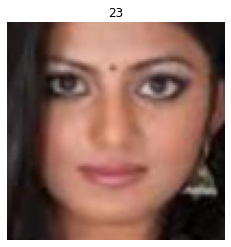

In [6]:
example_batch = train_ds.take(1) #Show one random image from dataset, including label

x, y = iter(example_batch).get_next() #x and y are one batch array of examples and labels

example_image = x[0]
example_label = y[0]

plt.imshow(example_image.numpy().astype("uint8"))
plt.title(example_label.numpy())
plt.axis("off")
plt.show()

To additionally check the import the shape of the the picture data and the labels is shown. Next, we can visualize the number of samples for each category and the number of distict labels.

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 100, 100, 3)
(32,)


In [8]:
from collections import defaultdict #Count the number of examples for each label

age_dist = defaultdict(int)

for x_batch,y_batch in train_ds.as_numpy_iterator():
   for i in range(len(y_batch)):
       age_dist[y_batch[i]] += 1


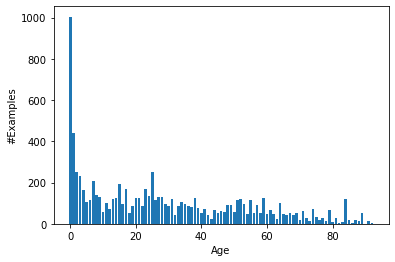

In [9]:
plt.bar(list(age_dist.keys()), age_dist.values()) #Plot above count
plt.xlabel('Age')
plt.ylabel('#Examples')
plt.show()

In [10]:
num_labels = len(list(age_dist.keys())) #Number of distinct labels:

print(num_labels)

93


# Prediction via Classification (One Class per Age)

For the first approach we define a neural network which should predict the age via classification. Each possible label is considered a class. The loss is defined accordingly. As the output is a probability distribution, it is possible to investigate
the most likely assignments (as opposed to the third approach, where we aim at directly predicting a continuous value).

First we define a basic model without dropout and batch normalization; both is added in a second step.

In [ ]:
# Define DNN with hidden layers. Rescale pixel values to [0, 1] first.
# There's one output class for each label.
# @see https://www.tensorflow.org/api_docs/python/tf/keras/layers

num_classes = num_labels

#Do not define activation function on output layer as recommended by TF documentation.
#Activation from using from_logits=True in loss function may offer better numerical stability.
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1.0 / 255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation = 'relu'),
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(num_classes)
])

#SparseCategoricalCrossentropy is to be used with integer labels (versus one-hot representation)
model.compile(
  optimizer = 'adam',
  loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
  metrics = ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])

Now we are ready to train the network. Please note the comments in the next cell; on slower machines, the training may take longer than one hour. A small value can be used for a rough test of the implementation.

In [ ]:
#Train model
epochs = 50 # 50 # (50 is the desired value, 2 is just for faster testing)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

print(model.summary())

The next cell visualizes the development of the accuracy and the loss on both the training data and the validation data during the training phase.

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

num_epochs = range(len(accuracy))

plot(num_epochs, accuracy, 'Accuracy Train', val_accuracy, 'Accuracy Validation', 'Train and Validation accuracy')

loss = history.history['loss']
val_loss = history.history['val_loss']

plot(num_epochs, loss, 'Loss Train', val_loss, 'Loss Validation', 'Train and Validation loss')

The next cell visualizes 9 random images from the dataset together with the real age, the predicted age and an average of
the 5 most probable ages according to the generated classification.

In [ ]:
#Show one random image from dataset, including label
example_batch = val_ds.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(y[i].numpy())
    plt.axis("off")
    plt.suptitle("Real")
    
plt.show()    
    
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    best_prediction = np.argmax(predictions)
    #No need to map prediction index to label, because they are identical in our case
    plt.title(best_prediction)
    plt.axis("off")
    plt.suptitle("Predicted (argmax)")
    
plt.show()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    avg = mean_avg_top_k(predictions)
    plt.title(avg)
    plt.axis("off")
    plt.suptitle("Predicted (top 5)")
    
plt.show()

In [ ]:
print("Predictions for last example:")
print(predictions)

Next we take the same approach as before but add dropout normalization and batch normalization.

In [11]:
# Define DNN with hidden layers. Rescale pixel values to [0, 1] first.
# There's one output class for each label.
# @see https://www.tensorflow.org/api_docs/python/tf/keras/layers

num_classes = num_labels

dropout_rate = 0.25

#Do not define activation function on output layer as recommended by TF documentation.
#Activation from using from_logits=True in loss function may offer better numerical stability.
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1.0 / 255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(512, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(256, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(num_classes)
])

#SparseCategoricalCrossentropy is to be used with integer labels (versus one-hot representation)
model.compile(
  optimizer = 'adam',
  loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
  metrics = ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])

In [12]:
#Train model
epochs = 50 # 60 # (60 is the desired value, 2 is just for faster testing)

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

print(model.summary())

Epoch 1/50
275/275 [==============================] - 14s 49ms/step - loss: 4.1179 - accuracy: 0.1146 - top_k_categorical_accuracy: 0.3498 - val_loss: 4.7421 - val_accuracy: 0.0656 - val_top_k_categorical_accuracy: 0.1200
Epoch 2/50
275/275 [==============================] - 13s 48ms/step - loss: 3.6427 - accuracy: 0.1381 - top_k_categorical_accuracy: 0.3098 - val_loss: 3.9453 - val_accuracy: 0.1097 - val_top_k_categorical_accuracy: 0.1856
Epoch 3/50
275/275 [==============================] - 13s 48ms/step - loss: 3.5139 - accuracy: 0.1503 - top_k_categorical_accuracy: 0.2937 - val_loss: 4.1704 - val_accuracy: 0.1179 - val_top_k_categorical_accuracy: 0.1979
Epoch 4/50
275/275 [==============================] - 13s 48ms/step - loss: 3.4671 - accuracy: 0.1553 - top_k_categorical_accuracy: 0.2840 - val_loss: 3.8890 - val_accuracy: 0.1056 - val_top_k_categorical_accuracy: 0.1415
Epoch 5/50
275/275 [==============================] - 13s 48ms/step - loss: 3.4152 - accuracy: 0.1583 - top_k_ca

Epoch 38/50
275/275 [==============================] - 13s 48ms/step - loss: 3.2423 - accuracy: 0.1710 - top_k_categorical_accuracy: 0.2855 - val_loss: 3.7803 - val_accuracy: 0.1487 - val_top_k_categorical_accuracy: 0.1938
Epoch 39/50
275/275 [==============================] - 13s 49ms/step - loss: 3.2397 - accuracy: 0.1731 - top_k_categorical_accuracy: 0.2835 - val_loss: 3.5807 - val_accuracy: 0.1590 - val_top_k_categorical_accuracy: 0.1692
Epoch 40/50
275/275 [==============================] - 14s 49ms/step - loss: 3.2368 - accuracy: 0.1675 - top_k_categorical_accuracy: 0.2822 - val_loss: 3.9242 - val_accuracy: 0.1303 - val_top_k_categorical_accuracy: 0.2195
Epoch 41/50
275/275 [==============================] - 14s 50ms/step - loss: 3.2219 - accuracy: 0.1723 - top_k_categorical_accuracy: 0.2845 - val_loss: 3.6929 - val_accuracy: 0.1713 - val_top_k_categorical_accuracy: 0.3631
Epoch 42/50
275/275 [==============================] - 14s 49ms/step - loss: 3.1991 - accuracy: 0.1694 - top

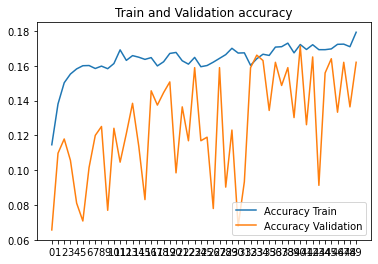

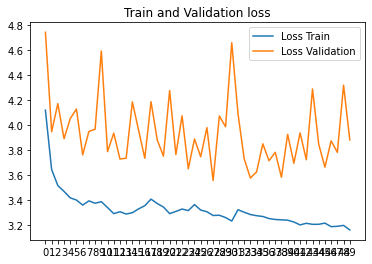

In [13]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

num_epochs = range(len(accuracy))

plot(num_epochs, accuracy, 'Accuracy Train', val_accuracy, 'Accuracy Validation', 'Train and Validation accuracy')

loss = history.history['loss']
val_loss = history.history['val_loss']

plot(num_epochs, loss, 'Loss Train', val_loss, 'Loss Validation', 'Train and Validation loss')

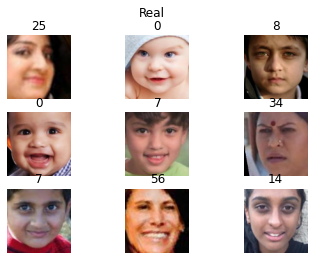

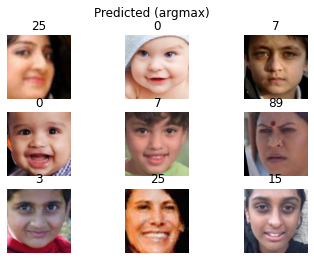

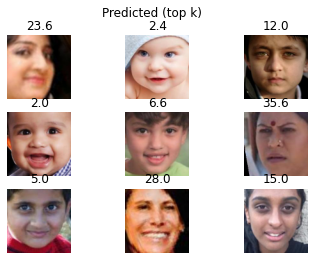

In [20]:
#Show one random image from dataset, including label

example_batch = val_ds.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(y[i].numpy())
    plt.axis("off")
    plt.suptitle("Real")
    
plt.show()    
    
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis = 0))
    best_prediction = np.argmax(predictions)
    #No need to map prediction index to label, because they are identical in our case
    plt.title(best_prediction)
    plt.axis("off")
    plt.suptitle("Predicted (argmax)")
    
plt.show()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis = 0))
    avg = mean_avg_top_k(predictions)
    plt.title(avg)
    plt.axis("off")
    plt.suptitle("Predicted (top k)")
    
plt.show()

# Prediction via Classification (One Class per Age Group)

The approach in this section also tries to predict the age by assignment to a class similar as before, but the data is remapped to a coarser partition of the age range. More precisely, each age is rounded down to the next smaller or equal age divisible by ten.

In [21]:
#Number of years to group together

age_grouping = 10

def label_group_mapping(x, y):
    return x, y // age_grouping

train_ds_grouped = train_ds.map(label_group_mapping)
val_ds_grouped = val_ds.map(label_group_mapping)

In [22]:
# Define DNN with hidden layers. Rescale pixel values to [0, 1] first.
num_classes = num_labels//age_grouping
if ((num_labels % age_grouping) != 0):
    num_classes += 1

print(f"Grouped {num_labels} labels to {num_classes} classes with stride {age_grouping}.")

dropout_rate = 0.1

#Do not define activation function on output layer as recommended by TF documentation.
#Activation from using from_logits=True in loss function may offer better numerical stability.
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1.0 / 255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(256, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(num_classes)
])

#SparseCategoricalCrossentropy is to be used with integer labels (versus one-hot representation)
model.compile(
  optimizer = 'adam',
  loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
  metrics = ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])

Grouped 93 labels to 10 classes with stride 10.


In [23]:
#Train model
epochs = 30 # (30 is the desired value, 2 is just for faster testing)

history = model.fit(
  train_ds_grouped,
  validation_data = val_ds_grouped,
  epochs = epochs
)

print(model.summary())

Epoch 1/30
275/275 [==============================] - 14s 48ms/step - loss: 1.7175 - accuracy: 0.4136 - top_k_categorical_accuracy: 0.5497 - val_loss: 1.6231 - val_accuracy: 0.4338 - val_top_k_categorical_accuracy: 0.6164
Epoch 2/30
275/275 [==============================] - 13s 48ms/step - loss: 1.4425 - accuracy: 0.4686 - top_k_categorical_accuracy: 0.5749 - val_loss: 1.8810 - val_accuracy: 0.3538 - val_top_k_categorical_accuracy: 0.4882
Epoch 3/30
275/275 [==============================] - 13s 48ms/step - loss: 1.3918 - accuracy: 0.4890 - top_k_categorical_accuracy: 0.5790 - val_loss: 1.9399 - val_accuracy: 0.3764 - val_top_k_categorical_accuracy: 0.9241
Epoch 4/30
275/275 [==============================] - 13s 48ms/step - loss: 1.3196 - accuracy: 0.5067 - top_k_categorical_accuracy: 0.5696 - val_loss: 1.6447 - val_accuracy: 0.4390 - val_top_k_categorical_accuracy: 0.8154
Epoch 5/30
275/275 [==============================] - 13s 48ms/step - loss: 1.2898 - accuracy: 0.5104 - top_k_ca

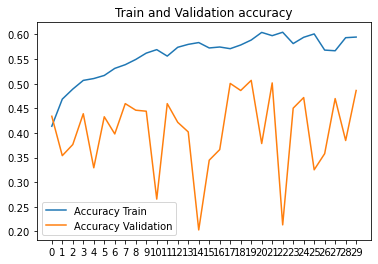

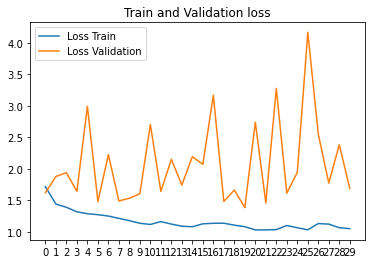

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

num_epochs = range(len(accuracy))

plot(num_epochs, accuracy, 'Accuracy Train', val_accuracy, 'Accuracy Validation', 'Train and Validation accuracy')

loss = history.history['loss']
val_loss = history.history['val_loss']

plot(num_epochs, loss, 'Loss Train', val_loss, 'Loss Validation', 'Train and Validation loss')

In [26]:
def to_grouped_age_range(age_class):
    lower_bound = age_class * age_grouping
    upper_bound = ( (age_class + 1) * age_grouping) - 1
    return "{} ({}-{})".format(age_class, lower_bound, upper_bound)

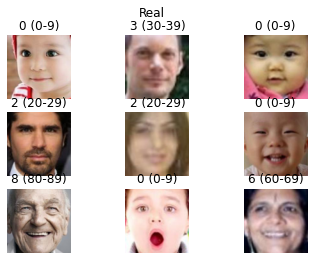

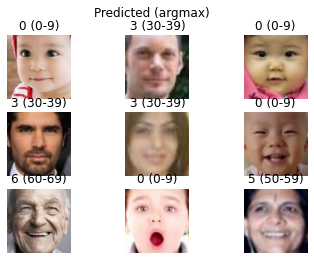

In [31]:
#Show one random image from dataset, including label
example_batch = val_ds_grouped.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(to_grouped_age_range(y[i].numpy()))
    plt.axis("off")
    plt.suptitle("Real")
    
plt.show()    
    
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    best_prediction = np.argmax(predictions)
    plt.title(to_grouped_age_range(best_prediction))
    plt.axis("off")
    plt.suptitle("Predicted (argmax)")
    
plt.show()

In [ ]:
print("Predictions for last example:")
print(predictions)
print(best_prediction)

# Prediction via Regression

As a third approach we can try to predict the age not by classification but as a single value. Intuitively this should permit to take into account that numerically similar ages are in fact similar permitted predictions; this is impossible using the two categorial apporoaches presented above.

In a first step, the dataset is remapped to use a float as a label type in order to permit scalar evaluation.

In [32]:
#Normalize life to a supposed lifespan of 100 years

def label_age_normalization(x, y):
    return x, tf.cast(y, tf.float32) / 100.0

# Remap data set

train_ds_age_normalized = train_ds.map(label_age_normalization)
val_ds_age_normalized = val_ds.map(label_age_normalization)

Next, a neural network is defined which is very similar to the ones before; however, there is finally only one output node as not a probability distribution but a single is desired as an oputput. Consequently, the loss is calculated via the mean squared error, as opposed to a loss which is suitable for assignment of categories.

In [33]:
dropout_rate = 0.1

#Do not define activation function on output layer as recommended by TF documentation.
#Activation from using from_logits=True in loss function may offer better numerical stability.
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(256, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1, activation = 'relu')
])

#SparseCategoricalCrossentropy is to be used with integer labels (versus one-hot representation)
model.compile(
  optimizer = 'adam',
  loss = tf.losses.MeanSquaredError(),
  metrics = ['mean_squared_error'])

As in the two previous approaches, the network needs to be trained. Please note the comment again, a smaller value
is suitable only to check whether the network can be trained in the first place.

In [34]:
#Train model

epochs = 30 # (30 is the desired value, 2 is just for faster testing)

history = model.fit(
  train_ds_age_normalized,
  validation_data = val_ds_age_normalized,
  epochs = epochs
)

print(model.summary())

Epoch 1/30
275/275 [==============================] - 14s 50ms/step - loss: 0.1143 - mean_squared_error: 0.1143 - val_loss: 0.0756 - val_mean_squared_error: 0.0756
Epoch 2/30
275/275 [==============================] - 13s 49ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0415 - val_mean_squared_error: 0.0415
Epoch 3/30
275/275 [==============================] - 13s 48ms/step - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 4/30
275/275 [==============================] - 13s 48ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 5/30
275/275 [==============================] - 13s 48ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 6/30
275/275 [==============================] - 14s 49ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 7/30
275/2

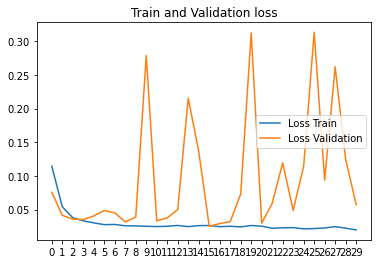

In [35]:
#Visualize progress of training

loss = history.history['loss']
num_epochs = range(len(loss))
val_loss = history.history['val_loss']

plot(num_epochs, loss, 'Loss Train', val_loss, 'Loss Validation', 'Train and Validation loss')

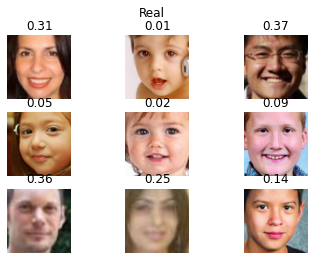

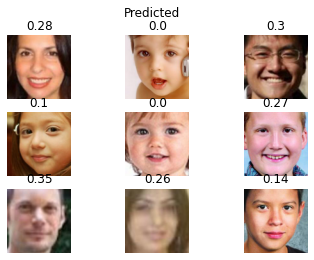

In [42]:
#Show one random image from dataset, including label

example_batch = val_ds_age_normalized.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(round(y[i].numpy(), 2))
    plt.axis("off")
    plt.suptitle("Real")
    
plt.show()    
    
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    plt.title(round(predictions[0][0], 2))
    plt.axis("off")
    plt.suptitle("Predicted")
    
plt.show()

# Interactive Part for Regression

In this part, a random picture from the validation data is selected. It is then presented to the user who can guess the age of the person shown. Afterwards, the predicted age of the person is shown. Finally, it is revealed how old the person acutally is based on the ground truth.

For the interaction, the upper cell needs to be executed only once to do some technical preparation. The lower cell can be executed repeatedly, but note that you need to actually reveal the real age, as otherwise the cell cannot be restarted as its execution is not finished.

In [ ]:
#Define helper function for showing picture and title, setup constants

example_age_prompt = "Let's Guess the age!"
keyboard_prompt = "Please press return."

def show_picture(picture, title):
    plt.imshow(picture.numpy().astype("uint8"))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
#Select one random image from dataset and generate prediction; on execution, every prompt for pressing return
#must be met, otherwise the cell does not terminate and cannot be restarted properly

example_batch = val_ds_age_normalized.take(1)

random_x,random_y = iter(example_batch).get_next()

example_image = random_x[0]
example_age_real = round(random_y[0].numpy(), 2)
example_age_predicted = round(model.predict(np.expand_dims(example_image, axis=0))[0][0], 2)

clear_output(wait = True)
show_picture(example_image, example_age_prompt)    #Show image with prompt
input(keyboard_prompt)

clear_output(wait = True)
show_picture(example_image, example_age_predicted) #Show image with predicted age
input(keyboard_prompt)

clear_output(wait = True)
show_picture(example_image, example_age_real)      #Show image with real age

# References:

* S. N. Kohail:  
Using Artificial Neural Network for Human Age Estimation Based on Facial Images  
2012 International Conference on Innovations in Information Technology (IIT)  
https://www.inf.uni-hamburg.de/en/inst/ab/lt/people/alumni/sarah-kohail/kohail-age-estimation.pdf

* Z. Qawaqneh, A. Abu Mallouh & B. D. Barkana:  
Deep Convolutional Neural Network for Age Estimation based on VGG-Face Model  
https://arxiv.org/ftp/arxiv/papers/1709/1709.01664.pdf

* N. Hewahi, A. Olwan, N. Tubeel, S. El-Asar, Z. Abu-Sultan:  
Age Estimation based on Neural Networks using Face Features  
Journal of Emerging Trends in Computing and Information Sciences 1:2, October 2010  
https://www.researchgate.net/publication/47277288_Age_Estimation_based_on_Neural_Networks_using_Face_Features

* R. Rahadian & S. Suyanto:  
Deep Residual Neural Network for Age Classification with Face Image  
2019 International Seminar on Research of Information Technology and Intelligent Systems (ISRITI)  
https://ieeexplore.ieee.org/document/9034664

* M. M. Islam & J.-H. Baek:  
Deep Learning Based Real Age and Gender Estimation from Unconstrained Face Image towards Smart Store Customer Relationship Management  
Applied Sciences 2021, 11  
https://www.mdpi.com/2076-3417/11/10/4549/pdf

* A. Othmania, A. R. Taleb, H. Abdelkawy & A. Hadid:  
Age estimation from faces using deep learning: A comparative analysis  
Computer Vision and Image Understanding 196, July 2020  
https://www.sciencedirect.com/science/article/abs/pii/S1077314220300424

* H. Han & C. Otto:
Age Estimation from Face Images: Human vs. Machine Performance
International Conference on Biometrics
https://www.researchgate.net/publication/235701854_Age_Estimation_from_Face_Images_Human_vs_Machine_Performance

Additional Links:

* https://towardsdatascience.com/age-detection-using-facial-images-traditional-machine-learning-vs-deep-learning-2437b2feeab2

* https://www.kaggle.com/frabbisw/facial-age